In [1]:
# Importing some libraries
import pandas as pd
import splusdata
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
import math as math
from astropy.io import fits
from astropy.table import Table
import os
import glob
import seaborn as sns
from IPython.display import clear_output
import astropy.units as u
import os
from datetime import datetime
from PIL import Image
import matplotlib.patches as patches
from astropy.io import fits
from astropy.table import Table, vstack

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None  # default='warn'

SEED = 333
np.random.seed(SEED)

# Algumas funções uteis pro futuro

In [3]:
# Importar algumas Funções uteis pro futuro


# Função para abrir um arquivo FITS
def fits_open(path, columns=None):  
    """
    Open a FITS file and convert it to a pandas DataFrame.

    :param path: Path to the FITS file.
    :param columns: List of columns to select from the FITS file.
    :return: Pandas DataFrame containing the FITS data.
    """
    with fits.open(path) as hdu:
        table = Table(hdu[1].data)
        df = table.to_pandas()
        
        # Select only the desired columns, if provided
        if columns is not None:
            df = df[columns]
        
        return df
    

# Função para salvar um DataFrame como um arquivo FITS
def save_as_fits(df, output_fits):
    """
    Salva um DataFrame como um arquivo FITS.

    :param df: DataFrame a ser salvo.
    :param output_fits: Caminho para o arquivo FITS de saída.
    """
    try:
        # Converter o DataFrame para uma tabela Astropy
        table = Table.from_pandas(df)
        
        # Escrever a tabela em um arquivo FITS
        table.write(output_fits, format='fits', overwrite=True)
        
        print(f"Arquivo FITS criado com sucesso: {output_fits}")
    except Exception as e:
        print(f"Erro ao salvar DataFrame como FITS: {e}")


# Função para criar colunas de cores em um DataFrame
def make_colors(df, colors, mag_type="PETRO_c"):
    """
    Cria colunas de cores em um DataFrame com base em magnitudes especificadas.

    :param df: DataFrame de entrada contendo as magnitudes.
    :param colors: Lista de strings representando as cores a serem criadas no formato 'col1-col2'.
    :param mag_type: Sufixo a ser adicionado aos nomes das colunas de magnitudes.
    :return: DataFrame com as colunas de cores adicionadas.
    """
    try:
        # Criar as cores com o sufixo especificado
        for color in colors:
            col1, col2 = color.split("-")
            col1_mag_type = f"{col1}_{mag_type}"
            col2_mag_type = f"{col2}_{mag_type}"
            df[color] = df[col1_mag_type] - df[col2_mag_type]

        return df
    except Exception as e:
        print(f"Error creating color columns: {e}")
        return df
    
    
# Função para baixar a imagem JPEG e opcionalmente desenhar um círculo
def legacy_image_plot(ra, dec, output_dir='legacy_images', layer='ls-dr10', zoom=False, pixscale=False, size=False, draw_circle=False, circle_radius=50, name_img=None):
    
    # Construir a URL
    if zoom and size:
        url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&zoom={zoom}&size={size}"
    
    elif size:
        url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&size={size}"
    
    elif pixscale:
        url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={pixscale}"
    else:
        url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}"
    
    response = requests.get(url)

    # Verificar se a resposta é bem-sucedida
    if response.status_code == 200:
        # Criar o diretório de saída, se não existir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Nome do arquivo JPG de saída
        if name_img:
            jpg_filename = f"{output_dir}/{name_img}_{ra}_dec{dec}.jpg"
        else:
            jpg_filename = f"{output_dir}/{ra}_dec{dec}.jpg"
        
        # Salvar o arquivo JPEG
        with open(jpg_filename, 'wb') as f:
            f.write(response.content)
        # print(f"Imagem JPG salva: {jpg_filename}")

        # Se a opção de desenhar o círculo estiver ativada, chamar a função para desenhar o círculo
        if draw_circle:
            plot_with_circle(jpg_filename, output_dir, circle_radius=circle_radius)
            # Remover a imagem original (sem círculo) se desejar
            os.remove(jpg_filename)
        
        return jpg_filename
    else:
        print(f"Erro ao baixar imagem para RA={ra}, DEC={dec}")
        return None


# Função para desenhar um círculo no centro da imagem sem borda branca
def plot_with_circle(image_path, save_path, circle_radius=50):
    img = Image.open(image_path)
    
    # Configurando o plot
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # Adicionando um círculo no centro da imagem
    center_x = img.width / 2
    center_y = img.height / 2
    circle = patches.Circle((center_x, center_y), circle_radius, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(circle)
    
    # Remover eixos e margens
    plt.axis('off')  # Desligar eixos
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remover margens
    
    # Salvar a imagem sem borda branca
    name_img = image_path.split('/')[-1]
    circled_filename = f"{save_path}/{name_img.replace('.jpg', '_circle.jpg')}"
    plt.savefig(circled_filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"Imagem com círculo salva: {circled_filename}")


# Download Tables Splus #

In [ ]:
conn = splusdata.connect('name', 'senha') ## from splus.cloud

You have access to internal data


In [17]:
fornax_fields = pd.read_csv(fr'/work1/pierre/Faculdade_teiu/Dados/Clusters/Fornax/fornax_fields.csv')


# for field in fornax_fields['Field']:  
    # print(fr"Baixando campo {field}")
    
fornax_fields_list = fornax_fields['Field'].tolist() 

print(len(fornax_fields_list))

106


In [26]:

# Deve ser uma lista com os nomes dos campos que você deseja baixar
for field in fornax_fields_list:

    caminho_salvar = fr"/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/{field}.fits"
    
    if os.path.exists(caminho_salvar):
        print(f"Arquivo {caminho_salvar} já existe, pulando campo {field}.")
        continue
    
    # Query para baixar os dados do campo com alguns parametros do idr4
    query = f"""SELECT 
            det.*,
            sqg.PROB_STAR,
            sqg.PROB_GAL,
            sqg.PROB_QSO,
            sqg.W1_MAG,
            sqg.W2_MAG,
            sqg.Gmag,
            sqg.PM,
            photoz.zml,
            photoz.odds
            FROM 
            idr5.idr5_dual AS det
            JOIN idr5_vacs.idr5_sqg AS sqg ON det.ID = sqg.ID
            JOIN idr5_vacs.idr5_photoz AS photoz ON det.ID = photoz.ID
            WHERE
            det.Field = '{field}'          
            """
    
    query_1 = f"""SELECT 
                    det.ID, 
                    det.RA,
                    det.DEC, 
                    f378.J0378_petro,
                    f395.J0395_petro,
                    f410.J0410_petro,
                    f430.J0430_petro,
                    f515.J0515_petro,
                    f660.J0660_petro,
                    f861.J0861_petro,
                    u.u_petro,
                    g.g_petro,
                    r.r_petro,
                    i.i_petro,
                    z.z_petro,                    
                    f378.J0378_aper_6,
                    f395.J0395_aper_6,
                    f410.J0410_aper_6,
                    f430.J0430_aper_6,
                    f515.J0515_aper_6,
                    f660.J0660_aper_6,
                    f861.J0861_aper_6,
                    u.u_aper_6,
                    g.g_aper_6,
                    r.r_aper_6,
                    i.i_aper_6,
                    z.z_aper_6,
                    f378.SEX_FLAGS_J0378,
                    f395.SEX_FLAGS_J0395,
                    f410.SEX_FLAGS_J0410,
                    f430.SEX_FLAGS_J0430,
                    f515.SEX_FLAGS_J0515,
                    f660.SEX_FLAGS_J0660,
                    f861.SEX_FLAGS_J0861,
                    u.SEX_FLAGS_u,
                    g.SEX_FLAGS_g,
                    r.SEX_FLAGS_r,
                    i.SEX_FLAGS_i,
                    z.SEX_FLAGS_z,         
                    sgq.PROB_STAR,
                    sgq.PROB_GAL,
                    sgq.PROB_QSO,
                    photz.zml,
                    photz.odds,
                    r.FWHM_n_r  
                    FROM 
                    idr4_dual.idr4_detection_image AS det
                    JOIN idr4_dual.idr4_dual_j0378 AS f378 ON det.ID = f378.ID
                    JOIN idr4_dual.idr4_dual_j0395 AS f395 ON det.ID = f395.ID
                    JOIN idr4_dual.idr4_dual_j0410 AS f410 ON det.ID = f410.ID
                    JOIN idr4_dual.idr4_dual_j0430 AS f430 ON det.ID = f430.ID
                    JOIN idr4_dual.idr4_dual_j0515 AS f515 ON det.ID = f515.ID
                    JOIN idr4_dual.idr4_dual_j0660 AS f660 ON det.ID = f660.ID
                    JOIN idr4_dual.idr4_dual_j0861 AS f861 ON det.ID = f861.ID
                    JOIN idr4_dual.idr4_dual_u AS u ON det.ID = u.ID
                    JOIN idr4_dual.idr4_dual_g AS g ON det.ID = g.ID
                    JOIN idr4_dual.idr4_dual_r AS r ON det.ID = r.ID
                    JOIN idr4_dual.idr4_dual_i AS i ON det.ID = i.ID
                    JOIN idr4_dual.idr4_dual_z AS z ON det.ID = z.ID
                    JOIN idr4_vacs.idr4_star_galaxy_quasar AS sgq ON det.ID = sgq.ID
                    JOIN idr4_vacs.idr4_photoz AS photz ON det.ID = photz.ID
                    WHERE
                    det.Field = '{field}'          
                    """

    query_field = query.replace('\n',' ')

    # Fazendo a consulta
    result = conn.query(query_field)

    print(fr"Salvando campo {field} em {caminho_salvar}")

    #salvando a query
    result.write(caminho_salvar, format='fits', overwrite=True)


Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s28.fits já existe, pulando campo SPLUS-s24s28.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s29.fits já existe, pulando campo SPLUS-s24s29.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s31.fits já existe, pulando campo SPLUS-s24s31.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s32.fits já existe, pulando campo SPLUS-s24s32.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s33.fits já existe, pulando campo SPLUS-s24s33.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s34.fits já existe, pulando campo SPLUS-s24s34.
Arquivo /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/SPLUS-s24s35.fits já existe, pulando campo SPLUS-

In [27]:
# Junta todos os arquivos FITS de um diretório em um único FITS

def stack_fits_in_dir(path_dir, output_fits):
    """
    Lê todos os arquivos FITS em um diretório, empilha as tabelas e salva em um único FITS.

    :param path_dir: Diretório contendo os arquivos FITS.
    :param output_fits: Caminho para o arquivo FITS de saída.
    """
    fits_files = glob.glob(os.path.join(path_dir, "*.fits"))
    tables = []
    for f in fits_files:
        with fits.open(f) as hdul:
            tables.append(Table(hdul[1].data))
    stacked = vstack(tables)
    stacked.write(output_fits, format='fits', overwrite=True)
    print(f"Arquivo FITS combinado salvo em: {output_fits}")


caminho_arqs = fr"/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/"

caminho_saida = fr"/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/saida_combinada.fits"
# Exemplo de uso:
stack_fits_in_dir(caminho_arqs, caminho_saida)

Arquivo FITS combinado salvo em: /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/saida_combinada.fits


# Correção Extinção

In [4]:
from astropy.coordinates import SkyCoord
import extinction
import numpy as np
import pandas as pd
from dustmaps.config import config
from astropy.io import fits
from astropy.table import Table
config['data_dir'] = './dustMaps'

import dustmaps.csfd
dustmaps.csfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [5]:
# Tem que ser o nome de como esta na tabela
mags = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']

# mags = ['u_aper_6', 'J0378_aper_6', 'J0395_aper_6', 'J0410_aper_6', 'J0430_aper_6',
        # 'g_aper_6', 'J0515_aper_6', 'r_aper_6', 'J0660_aper_6', 'i_aper_6', 'J0861_aper_6', 'z_aper_6']

# To calculate extinctions
def correct_extinction(dataframe, extinction_maps, extinction_columns):
    '''
    Correct the magnitudes for extinction using the CCM89 Law

    Keyword arguments:
    dataframe         -- dataframe containing the data to be corrected
    extinction_maps   -- SFD Maps
    '''
    corrected_df = dataframe.copy().reset_index(drop=True)

    # Obtaining E(B-V) and Av in a given RA, DEC position
    input_file_coords = SkyCoord(dataframe['RA'], dataframe['DEC'], frame='icrs', unit='deg')
    ebv = extinction_maps(input_file_coords)
    av  = 3.1*ebv

    # Calculating the extinction on the S-PLUS bands using the Cardelli, Clayton & Mathis law.
    Lambdas = np.array([1549.02, 2304.74,                                                        # FUV, NUV
                        3536, 3770, 3940, 4094, 4292, 4751, 5133, 6258, 6614, 7690, 8611, 8831,  
                        10210, 12540, 16460, 21490,                                              # Y, J, H, K - http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
                        33526.00, 46028.00]).astype(float)                                       # W1, W2

    extinctions = []
    for i in range(len(av)):
        extinctions.append(extinction.ccm89(Lambdas, av[i], 3.1))

    extinction_df = pd.DataFrame(extinctions, columns=[extinction_columns])

    for i in range(len(extinction_columns)):
        corrected_df[extinction_columns[i]] = extinction_df[extinction_columns[i]]
        
    #corrected_df['EBV'] = ebv

    return corrected_df


# Essa função muda dependendo do nome das colunas que você tem no seu DataFrame 
# ideia aqui é fazer uma coluna nova (exemplo: mag_petro_u_c) que é a coluna mag_petro_u corrigida pela extinção, usando a coluna mag_petro_u e a coluna u_ext
# e assim por diante para as outras magnitudes

def create_corrected_mags(df, mags):
    for mag in mags:        
        df[f"{mag}_petro_c"] = df[f"{mag}_petro"] - df[f"{mag}_ext"]
        df[f"{mag}_aper_6_c"] = df[f"{mag}_aper_6"] - df[f"{mag}_ext"]
        df[f"{mag}_aper_3_c"] = df[f"{mag}_aper_3"] - df[f"{mag}_ext"]
        df[f"{mag}_auto_c"] = df[f"{mag}_auto"] - df[f"{mag}_ext"]
        df[f"{mag}_iso_c"] = df[f"{mag}_iso"] - df[f"{mag}_ext"]

    return df


# Filters
features_SPLUS = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
# features_SPLUS = ['U', 'F378', 'F395', 'F410', 'F430', 'G', 'F515', 'R', 'F660', 'I', 'F861', 'Z']
extinct_SPLUS = [filt+'_ext' for filt in features_SPLUS]

features_WISE = ['W1_ab', 'W2_ab']
extinct_WISE  = [filt+'_ext' for filt in features_WISE]

features_VHS = ['Ypmag', 'Jpmag', 'Hpmag', 'Kspmag']
extinct_VHS  = [filt+'_ext' for filt in features_VHS]

features_GALEX = ['FUVmag', 'NUVmag']
extinct_GALEX  = [filt+'_ext' for filt in features_GALEX]

features    = features_SPLUS + features_WISE + features_VHS + features_GALEX
extinctions = extinct_SPLUS + extinct_WISE + extinct_VHS + extinct_GALEX

In [6]:
# Load dust map
csfd_map = dustmaps.csfd.CSFDQuery(map_fname='dustMaps/csfd/csfd_ebv.fits', mask_fname='dustMaps/csfd/mask.fits')

In [7]:
fornax_idr5_corrected = pd.read_parquet(fr'/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/fornax_idr5_corrected.parquet')

In [9]:
save_as_fits(fornax_idr5_corrected, fr'/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/fornax_idr5_corrected.fits')

Arquivo FITS criado com sucesso: /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/fornax_idr5_corrected.fits


In [9]:
# Df para ser corrigido
output_fits = '/work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/corrected_data.fits'

dataframe_corrected = correct_extinction(dataframe, csfd_map, extinctions)
corrected_mags = create_corrected_mags(dataframe_corrected, features_SPLUS)

# Save the corrected DataFrame as a FITS file
# save_as_fits(corrected_mags, output_fits)
print(f"DataFrame corrigido salvo como {output_fits}")

DataFrame corrigido salvo como /work1/pierre/Faculdade_teiu/Dados/Fotometric/SPLUS/idr5_SPLUS/Fornax_idr5_new/corrected_data.fits


# Criando PhotoSpecs

In [109]:
arq_ex_photospecs = pd.read_csv(fr'/home/pierre/Downloads/agn_sample.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


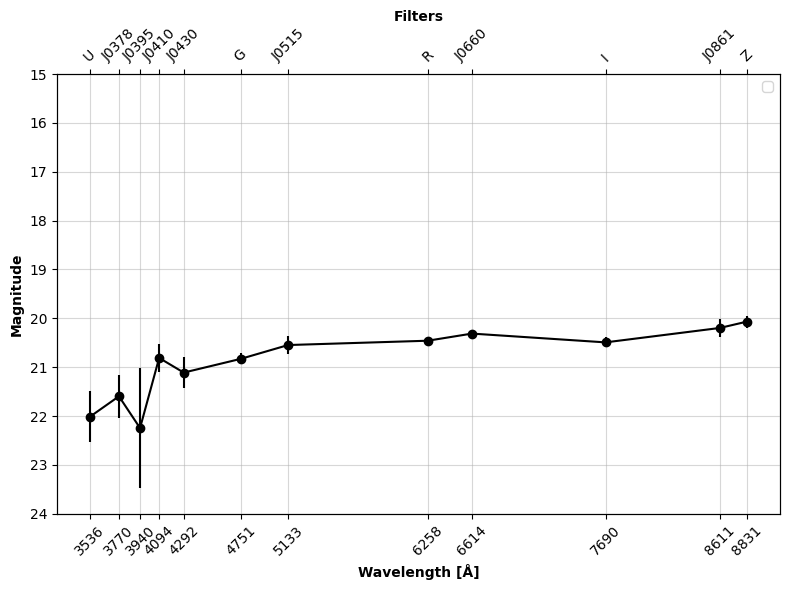

In [ ]:
#  Nomes dos filtros do S-PLUS e suas respectivas posições centrais em Ångstrons
filters = ['U', 'J0378', 'J0395', 'J0410', 'J0430', 'G', 'J0515', 'R', 'J0660', 'I', 'J0861', 'Z']
wavelengths = [3536, 3770, 3940, 4094, 4292, 4751, 5133, 6258, 6614, 7690, 8611, 8831]


mags_auto = ["mag_auto_u", "mag_auto_j0378", "mag_auto_j0395", "mag_auto_j0410", "mag_auto_j0430", "mag_auto_g", "mag_auto_j0515", "mag_auto_r", "mag_auto_j0660", "mag_auto_i", "mag_auto_j0861", "mag_auto_z"]

errors_auto = ["err_mag_auto_u", "err_mag_auto_j0378", "err_mag_auto_j0395", "err_mag_auto_j0410", "err_mag_auto_j0430", "err_mag_auto_g", "err_mag_auto_j0515", "err_mag_auto_r", "err_mag_auto_j0660", "err_mag_auto_i", "err_mag_auto_j0861", "err_mag_auto_z"]


obj_1 = arq_ex_photospecs.iloc[[10]]
mags_plot = obj_1[mags_auto]
mags_plot = mags_plot.values.reshape(-1,)
errors_list = obj_1[errors_auto]


# Criar a figura e os eixos fora do loop
fig, ax1 = plt.subplots(figsize=(8, 6))


ax1.errorbar(wavelengths, mags_plot, yerr=errors_list, fmt='-o', color='black')


# Ajustes do gráfico
ax1.invert_yaxis()
ax1.set_xticks(wavelengths)
ax1.set_xticklabels(wavelengths, rotation=45)
ax1.set_xlabel('Wavelength [Å]', fontweight='bold')
ax1.set_ylabel('Magnitude', fontweight='bold')
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.5)

# Criar um segundo eixo X para os filtros
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(wavelengths)
ax2.set_xticklabels(filters, rotation=45, size=10)
ax2.set_xlabel('Filters', fontweight='bold')

ax2.set_ylim(24, 15)

# Ajustar a ordem de desenho dos eixos
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # Remove o fundo do ax1
ax2.set_zorder(0)  

# Exibir o gráfico
plt.tight_layout()
plt.show()